# Imports

In [83]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import sys, os
from glob import glob
import imageio
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

# Data Preprocessing


In [84]:
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/00278/SEMG_DB1.rar

File ‘SEMG_DB1.rar’ already there; not retrieving.



In [85]:
!unrar e  SEMG_DB1.rar


UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal


Extracting from SEMG_DB1.rar


Would you like to replace the existing file 10Amar.log
275168 bytes, modified on 2013-04-27 11:09
with a new one
275168 bytes, modified on 2013-04-27 11:09

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit E

Extracting  10Amar.txt                                                    23% 24%  OK 
Extracting  10Apie.txt                                                    24% 25%  OK 
Extracting  10Asen.txt                                                    25% 26%  OK 
Extracting  11Amar.txt                                                    26% 27%  OK 
Extracting  11Apie.txt                                                    27% 28%  OK 
Extracting  11Asen.txt                                                    28% 29%  OK 
Extracting  1Amar.txt                                                     30% 

In [86]:
!mkdir data
!mkdir data/A
!mkdir data/N
!mv [1-9]A*.txt data/A
!mv [1-9]N*.txt data/N
!mv 1[0-9]A*.txt data/A
!mv 1[0-9]N*.txt data/N

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/A’: File exists
mkdir: cannot create directory ‘data/N’: File exists


In [87]:
def read_folder(path): 
  folder_con = []
  file_name = []
  n = 1
  for file in os.listdir(path):
      if file.endswith(".txt"):
          file_path = f"{path}/{file}"
          df = pd.read_csv(file_path, sep='\t', skiprows=list(range(7)), header=None).dropna()
          
          if len(df.columns) == 6:
            df.drop(columns=df.columns[-2:], axis=1, inplace=True)
          if len(df.columns) == 5:
            df.drop(columns=df.columns[-1:], axis=1, inplace=True)
          
          folder_con.append(df)
          file_name.append(file_path)
          n = n + 1
          
  return folder_con, file_name

In [88]:
A_folder_con, A_name = read_folder('data/A')
N_folder_con, N_name = read_folder('data/N')
A_final_data = pd.concat(A_folder_con, ignore_index=True)
N_final_data = pd.concat(N_folder_con, ignore_index=True)
A_torch_data = torch.tensor(A_final_data.values)
N_torch_data = torch.tensor(N_final_data.values)

In [89]:
def image_creator(data, label, wid_len=256, stride=128):
  i = 0
  num = 0
  img_list = []
  while True:
    img = data[i: i+wid_len]
    # img_list.append(img)
    i = i + stride
    num = num + 1 
    new = []
    new.append(img.reshape(1, wid_len, 4))
    new.append(label)
    img_list.append(new)
    if num == int(((len(data) - wid_len) / stride + 1)):
      break
  return img_list
  

In [90]:
N_list = image_creator(N_torch_data, label=0, wid_len=256, stride=128)
A_list = image_creator(A_torch_data, label=1, wid_len=256, stride=128)
data = A_list + N_list

In [91]:
class MyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data_frame = data
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = self.data_frame[idx][0]
        label = self.data_frame[idx][1]
        
        if self.transform:
            image = self.transform(image)
            image = image.double()

        return image, label

In [92]:
plt.imshow(data[0][0].squeeze(), cmap="gray")
plt.axis(False)
plt.show()

In [93]:
train, test = train_test_split(data, test_size=0.33, shuffle=True)

In [94]:
test[0]

[tensor([[[-0.0091, -0.0008,  0.0090,  0.0000],
          [-0.0120, -0.0008,  0.0052,  0.0007],
          [-0.0105,  0.0007,  0.0007,  0.0007],
          ...,
          [-0.0053,  0.0007,  0.0007,  0.0015],
          [-0.0023,  0.0007,  0.0045,  0.0015],
          [-0.0060, -0.0008,  0.0060,  0.0030]]], dtype=torch.float64),
 1]

In [95]:
train_dataset = MyDataset(train)
test_dataset = MyDataset(test)
# Data loader
batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)


test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


# Network Implementation

In [96]:
class Reshape(nn.Module):
  def __init__(self, *args):
      super().__init__()
      self.shape = args

  def forward(self, x):
      return x.view(self.shape)

class Trim(nn.Module):
  def __init__(self, *args):
      super().__init__()

  def forward(self, x):
      return x[:, :, :256, :]



class Encoder(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
        nn.LeakyReLU(0.01),
        nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
        nn.LeakyReLU(0.01),
        nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
        nn.Flatten(),
        nn.Linear(64*64*1, 2)
    )

  def forward(self, x):
      x = self.encoder(x)
      return x
    

  

class Decoder(nn.Module):
  def __init__(self):
    super().__init__()

    self.decoder = nn.Sequential(
        nn.Linear(2, 64*64*1),
        Reshape(-1, 64, 64, 1),
        nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
        nn.LeakyReLU(0.01),
        nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),                
        nn.LeakyReLU(0.01),
        nn.ConvTranspose2d(64, 1, stride=(2, 2), kernel_size=(4, 4), padding=0),                
        nn.Sigmoid()
        )

  def forward(self, x):
      x = self.decoder(x)
      return x
    

In [97]:
encoder = Encoder()
decoder = Decoder()

In [98]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
encoder.to(device)
decoder.to(device)

cuda:0


Decoder(
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=4096, bias=True)
    (1): Reshape()
    (2): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
    (7): Sigmoid()
  )
)

In [99]:
from torchsummary import summary
summary(encoder, (1, 256, 4))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 256, 4]             320
         LeakyReLU-2           [-1, 32, 256, 4]               0
            Conv2d-3           [-1, 64, 128, 2]          18,496
         LeakyReLU-4           [-1, 64, 128, 2]               0
            Conv2d-5            [-1, 64, 64, 1]          36,928
           Flatten-6                 [-1, 4096]               0
            Linear-7                    [-1, 2]           8,194
Total params: 63,938
Trainable params: 63,938
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.81
Params size (MB): 0.24
Estimated Total Size (MB): 1.06
----------------------------------------------------------------


In [100]:
summary(decoder, (1, 2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 4096]          12,288
           Reshape-2            [-1, 64, 64, 1]               0
   ConvTranspose2d-3            [-1, 64, 64, 1]          36,928
         LeakyReLU-4            [-1, 64, 64, 1]               0
   ConvTranspose2d-5           [-1, 64, 127, 1]          36,928
         LeakyReLU-6           [-1, 64, 127, 1]               0
   ConvTranspose2d-7            [-1, 1, 256, 4]           1,025
           Sigmoid-8            [-1, 1, 256, 4]               0
Total params: 87,169
Trainable params: 87,169
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.26
Params size (MB): 0.33
Estimated Total Size (MB): 0.60
----------------------------------------------------------------


In [101]:
encoder.double()

Encoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=4096, out_features=2, bias=True)
  )
)

In [102]:
decoder.double()

Decoder(
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=4096, bias=True)
    (1): Reshape()
    (2): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
    (7): Sigmoid()
  )
)

In [103]:
criterion = torch.nn.MSELoss()
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optimizer = torch.optim.Adam(params_to_optimize, lr=0.0001, weight_decay=1e-05)

In [104]:
def batch_gd(criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    encoder.train()
    decoder.train()
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()
      encoded_data = encoder(inputs)
      decoded_data = decoder(encoded_data)
      loss = criterion(decoded_data, inputs)
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())
    train_loss = np.mean(train_loss)

    encoder.eval()
    decoder.eval()
    with torch.no_grad():
      test_loss = []
      for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        encoded_data = encoder(inputs)
        decoded_data = decoder(encoded_data)
        loss = criterion(decoded_data, inputs)
        test_loss.append(loss.item())
      test_loss = np.mean(test_loss)

      train_losses[it] = train_loss
      test_losses[it] = test_loss


      dt = datetime.now() - t0
      print(f"Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration:{dt}")

  return train_losses, test_losses



# Model Train and Resualts

In [105]:
train_losses, test_losses = batch_gd(
    criterion, optimizer, train_loader, test_loader, epochs=10
)

Epoch 1/10, Train Loss: 0.2184,       Test Loss: 0.2045, Duration:0:00:05.289300
Epoch 2/10, Train Loss: 0.1411,       Test Loss: 0.0450, Duration:0:00:05.209713
Epoch 3/10, Train Loss: 0.0125,       Test Loss: 0.0034, Duration:0:00:05.236071
Epoch 4/10, Train Loss: 0.0031,       Test Loss: 0.0028, Duration:0:00:05.274625
Epoch 5/10, Train Loss: 0.0028,       Test Loss: 0.0027, Duration:0:00:05.289441
Epoch 6/10, Train Loss: 0.0027,       Test Loss: 0.0026, Duration:0:00:05.332117
Epoch 7/10, Train Loss: 0.0027,       Test Loss: 0.0026, Duration:0:00:05.313534
Epoch 8/10, Train Loss: 0.0027,       Test Loss: 0.0026, Duration:0:00:05.301004
Epoch 9/10, Train Loss: 0.0026,       Test Loss: 0.0026, Duration:0:00:05.275667
Epoch 10/10, Train Loss: 0.0026,       Test Loss: 0.0026, Duration:0:00:05.246138


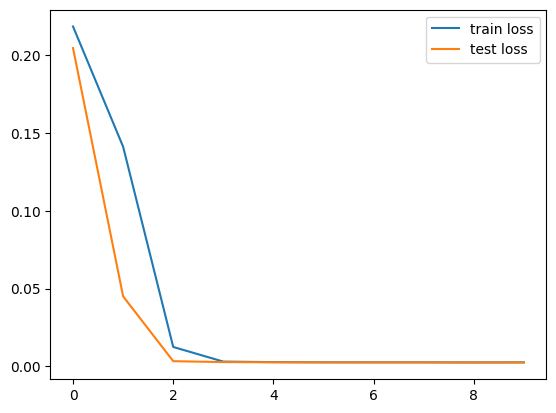

In [106]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

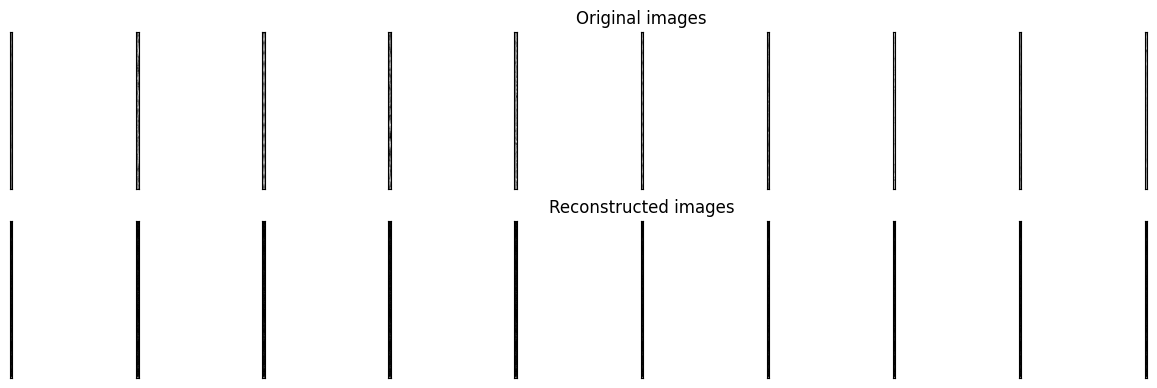

In [107]:
plt.figure(figsize=(16, 4.5))
n = 10
for i in range(n):
  ax = plt.subplot(2, n, i+1)
  img = test[i][0].unsqueeze(0).to(device)
  encoder.eval()
  decoder.eval()
  with torch.no_grad():
      rec_img  = decoder(encoder(img))
  plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)  
  if i == n//2:
    ax.set_title('Original images')
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)  
  if i == n//2:
      ax.set_title('Reconstructed images')
plt.show()   

In [108]:
torch.save(encoder, 'Encoder.pth')
torch.save(decoder, 'Decoder.pth')